First of all, we import some functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from photutils.segmentation import make_source_mask
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from scipy import optimize as opt
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import simple_norm
from photutils.datasets import make_100gaussians_image
from photutils.segmentation import detect_threshold, detect_sources
from scipy import ndimage as ndi
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.modeling import models, fitting
from photutils.centroids import centroid_com
from matplotlib.ticker import FormatStrFormatter
import os
import imageio
from IPython.display import display, Math, Latex

# Introduction

In this exercise we are going to work with a data cube in order to obtain some features of the galaxy ESO113-G032: find the areas of stelar formation, identify some emissions lines, obtain its redshift and plot its rotation curve.

# Fundamentals

We do all the work with a data cube. A data cube is a multidementional (3 in our case) array of values. Each dimention correspond to a magnitude. We do integral field spectroscopy, which consists in obtaining the spectra (flux vs. wavelength) of each point contained in a huge area of the sky. Attending to this, the first dimention (the 0-component) of our data cube are the fluxes for a large range of channels (each channel corresponds to a wavelength value), the second and third dimentions correspond to the coordinates of a pixel of the area of the sky mentioned (the distance between pixels can be converted into physical distance).

With these data we can select diferent pixels and get their spectra, sum images for ranges of wavelengths, localize areas of stelar formation, find emission lines and much more.

Moreover, it will be useful to know that given a disc with elliptical shape in rotation, if the disc is inclined an angle $i$ respect to a plane that faces us and we want to know the rotation velocity $v_r$ of a point at an angle $\theta$ respect to the major axis in polar coordinates centered at the ellipse, the observed velocity $v_{obs}$ and the rotation velocity around the centered are related as:

In [2]:
display(Math(r'v_r = \frac{v_{obs}}{\cos \theta \sin i}'))

<IPython.core.display.Math object>

# Realization

We define a function which will be very helpful. It will allow as to easily calculate imporatant statistical values of our images.

In [3]:
def imstatsa(arr):
    """
    
    Parameters
    ----------
    image : array
        data of the image

    Returns
    -------
    a dictionary with the following components:
        number of pixels : integer
        minimum number of counts in a pixel : integer
        maximum number of counts in a pixel : integer
        mean of counts in all pixels : float
        median of counts in all pixels : integer
        standard deviation of the counts in all pixels : float
    
    It takes into account that some values can be zero, such values are eliminated of the stadistic: using "nan" after
    writing np.
        
    Example
    -------
    In: imstats('r326214.fits')
    Out: {'pixels': 4426560, 'minimum': 514, 'maximum': 3862, 'mean': 541.0289572489698,'median': 541.0, 
    'standard deviation': 5.29484102604657}
    """

    return {'pixels': arr.shape[0]*arr.shape[1], 'minimum': np.nanmin(arr), 'maximum': np.nanmax(arr), 
            'mean': np.nanmean(arr), 'median': np.nanmedian(arr), 'standard deviation': np.nanstd(arr)}

## 1.1. Load our data cube.

In [4]:
hdul = fits.open("/Users/Fran/Desktop/Tecnicas_observacionales/ESO113-G032.fits") # substitute the path
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x00000158512BBF48>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x00000158513E71C8>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x00000158513EEAC8>]

## 1.2. Read the header and extract some relevant information of it.

In [5]:
hdul[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  408 / length of data axis 1                          
NAXIS2  =                  327 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ZBLANK  =          -2147483647 / null value in the compressed integer array     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

Some important values are extacted below (dimention number, axis lengths, pixel scale and wavelegth step, the wavelength corresponding to the first channel, this is "ReferenceWavelength"), and the references values of the pixels to transform from pixels to rigth ascension and declination:

In [6]:
DimentionNumber = hdul[1].header["NAXIS"]
AxisLength1 = hdul[1].header["NAXIS1"]
AxisLength2 = hdul[1].header["NAXIS2"]
AxisLength3 = hdul[1].header["NAXIS3"]
PixelScale = hdul[1].header["CD1_1"] # it is equal to "CD2_2" because our pixels are square
StepWavelength = hdul[1].header["CD3_3"]
ReferenceWavelength = hdul[1].header["CRVAL3"]
PixelReferenceXor1 = hdul[1].header["CRPIX1"]
PixelReferenceYor2 = hdul[1].header["CRPIX2"]
ValueofReferenceX = hdul[1].header["CRVAL1"]
ValueofReferenceY = hdul[1].header["CRVAL2"]
print(' Dimention number = %i \n\n' %DimentionNumber,'x axis length = %i \n\n' %AxisLength1,
      'y axis length = %i \n\n' %AxisLength2, 'Wavelength axis length = %i \n\n' %AxisLength3,
      'Pixel scale = %f \n\n' %PixelScale, 'Wavelength step = %0.2f \n\n' %StepWavelength,
      'Wavelength reference = %i \n\n' %ReferenceWavelength, 'Reference pixel in x axis = %i \n\n' %PixelReferenceXor1,
      'Reference pixel in y axis = %i \n\n' %PixelReferenceYor2, 
      'Value of RA in reference pixel in x axis = %.2f \n\n' %ValueofReferenceX,
      'Value of Dec in reference pixel in y axis = %.2f' %ValueofReferenceY)

 Dimention number = 3 

 x axis length = 408 

 y axis length = 327 

 Wavelength axis length = 3681 

 Pixel scale = -0.000056 

 Wavelength step = 1.25 

 Wavelength reference = 4749 

 Reference pixel in x axis = 163 

 Reference pixel in y axis = 160 

 Value of RA in reference pixel in x axis = 19.03 

 Value of Dec in reference pixel in y axis = -61.62


## 1.3. Shape of our cube.

The shape of our cube is shown next

In [7]:
hdul[1].data.shape

(3681, 327, 408)

It can be appreciated that they are equal to the values extracted from the header (axis legths values), in order: (AxisLength3, AxisLength2. AxisLength1). Axis 1 corresponds to the x axis of our images, axis 2 to the y axis of our images and axis 3 to the wavelength channels. 

It will be helpful to use functions as conversors between wavelength values and channels along the axis 3.

Given a channel, the corresponding wavelength value is calculated as

In [8]:
def ToWavelengthFuntion(Channel):
    return ReferenceWavelength + Channel*StepWavelength

Given a wavelength value, its corresponding channel can be obtained as follows.

In [9]:
def ToChannelFunction(Wavelength):
    return int((Wavelength-ReferenceWavelength)/StepWavelength)

Notice that a channel must be an integer, so we use the function int() to solve this issue.

## 1.4. Representation of the galaxy for a fixed wavelength value.

In [10]:
data = hdul[1].data

We will represent our galaxy for the wavelengths of 5000, 6000 and 7000 amstrong.

In [11]:
Wavelengths = [5000, 7500, 9000]
Channels = [ToChannelFunction(wavelength) for wavelength in Wavelengths]

In [12]:
Channels

[200, 2200, 3400]

In [13]:
Images = [data[Channel, :, :] for Channel in Channels]

<function matplotlib.pyplot.show(close=None, block=None)>

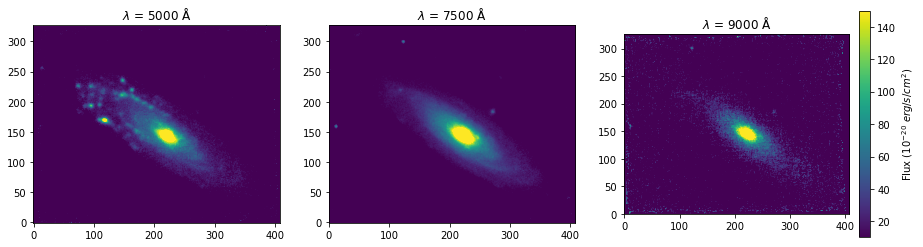

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
ax1.imshow(Images[0], vmin= 10, vmax=150, origin='lower')
ax2.imshow(Images[1], vmin= 10, vmax=150, origin='lower')
z3plt = ax3.imshow(Images[2], vmin= 10, vmax=150, origin='lower', ) # The colorbar is only put beside the third plot since it 
# represents the same for every plot.
ax1.set_title(r'$\lambda $ = %i Å' % Wavelengths[0])
ax2.set_title(r'$\lambda $ = %i Å' % Wavelengths[1])
ax3.set_title(r'$\lambda $ = %i Å' % Wavelengths[2])
plt.colorbar(z3plt, ax=ax3, label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.046, pad=0.04)
plt.show

## 1.5. Spectrum for the complete range of wavelength for some pixels.

We must transform our x axis in the axis of the wavelengths

In [15]:
xdata = ReferenceWavelength + np.arange(len(data))*StepWavelength

And now we can do the plots for diferent pixels: (100, 200), (221, 145) and (250, 150), where they are presented as (x-coordinate, y-coordinate). The y-data of yhe plot (the flux), can be obtained for the dirent pixels as follows

In [16]:
pixel1 = [200, 100]
pixel2 = [145, 221]
pixel3 = [150, 250]
pixels = [pixel1, pixel2, pixel3]

In [17]:
ydatapixels = [data[:, pixel[0], pixel[1]] for pixel in pixels]

The plots are now made. The pixels are also shown in the image for a wavelength of 5000 amstrong.

<function matplotlib.pyplot.show(close=None, block=None)>

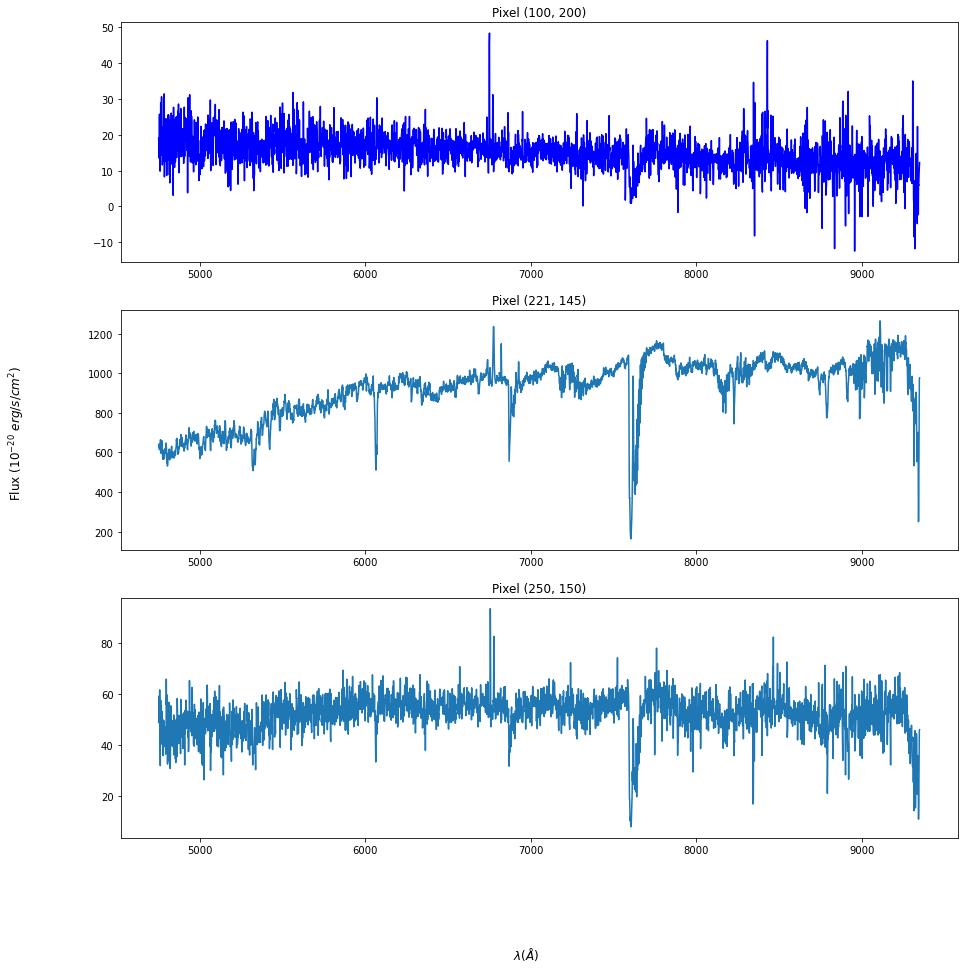

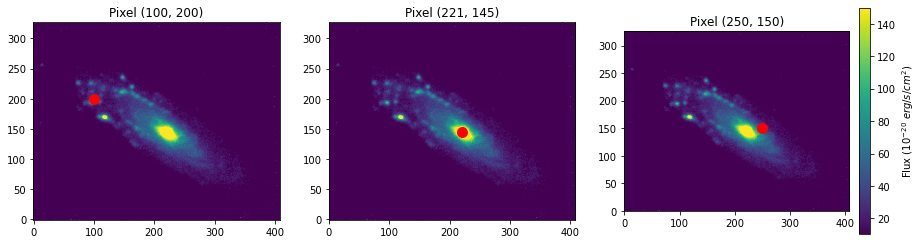

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))
ax1.plot(xdata, ydatapixels[0], '-b')
ax2.plot(xdata, ydatapixels[1])
ax3.plot(xdata, ydatapixels[2])
ax1.set_title('Pixel (100, 200)')
ax2.set_title('Pixel (221, 145)')
ax3.set_title('Pixel (250, 150)')
fig.supxlabel(r'$\lambda (Å)$')
fig.supylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
plt.show
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
ax1.imshow(Images[0], vmin= 10, vmax=150, origin='lower')
ax2.imshow(Images[0], vmin= 10, vmax=150, origin='lower')
z3plt = ax3.imshow(Images[0], vmin= 10, vmax=150, origin='lower', )
ax1.set_title('Pixel (100, 200)')
ax2.set_title('Pixel (221, 145)')
ax3.set_title('Pixel (250, 150)')
ax1.plot(pixel1[1], pixel1[0], 'ro', markersize=10)
ax2.plot(pixel2[1], pixel2[0], 'ro', markersize=10)
ax3.plot(pixel3[1], pixel3[0], 'ro', markersize=10)
plt.colorbar(z3plt, ax=ax3, label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.046, pad=0.04)
plt.show

If we observe negative values for the flux in the first spectra, it is beacause a reduction problem, these values can be kept or substituted by nans.

## 1.6. Find the center of the galaxy for all the wavelengths.

We can conatenate all the images into one, which will be the sum of all the wavelenths.

In [19]:
ImageAllambda = np.sum(hdul[1].data,  axis=0)/AxisLength3

And now we can obtain the center the galaxy in this image.

First we try with the coordinates of the NED Catalog (this is done using the transformation matrix to transform form declination and rigth ascension to pixels) , but we see that it does not match. This is probably because the reference values on the header to create this matrix are not right.

In [20]:
CoordinatesGalaxyNED = [19.020583, -61.622167] #RA, Dec in Deg
CoordinatesGalaxyNEDPixelx = (CoordinatesGalaxyNED[0]-ValueofReferenceX)/PixelScale+PixelReferenceXor1
CoordinatesGalaxyNEDPixely = (CoordinatesGalaxyNED[1]-ValueofReferenceY)/PixelScale*-1+PixelReferenceYor2

<function matplotlib.pyplot.show(close=None, block=None)>

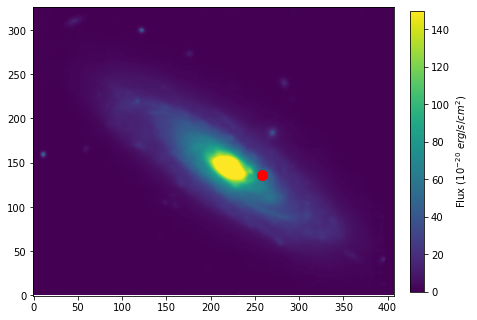

In [21]:
plt.figure(figsize=(7,7))
plt.imshow(ImageAllambda, origin='lower', vmin=0, vmax=150)
plt.plot(CoordinatesGalaxyNEDPixelx, CoordinatesGalaxyNEDPixely, 'ro', markersize=10)
plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.036, pad=0.04)
plt.show

We can try using the function "centroid_com" in a small square around the bulb of the galaxy.

In [22]:
coordinadascentroid = centroid_com(ImageAllambda[141:152, 219:225], mask=None, oversampling=1)
CoordinatesGalaxyCentroidxRelative = coordinadascentroid[0]
CoordinatesGalaxyCentroidyRelative = coordinadascentroid[1]
CoordinatesGalaxyCentroidx = int(CoordinatesGalaxyCentroidxRelative+219)
CoordinatesGalaxyCentroidy = int(CoordinatesGalaxyCentroidyRelative+141)

xvalue = 221 ; yvalue = 145


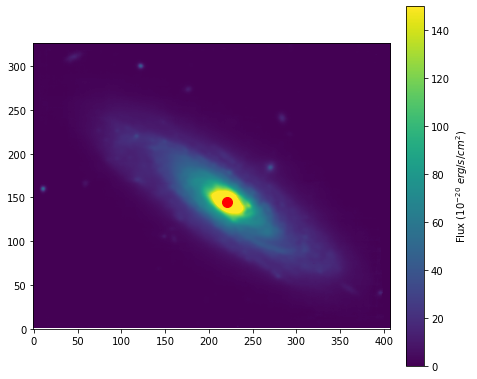

In [23]:
plt.figure(figsize=(7,7))
plt.imshow(ImageAllambda, origin='lower', vmin=0, vmax=150)
plt.plot(CoordinatesGalaxyCentroidx, CoordinatesGalaxyCentroidy, 'ro', markersize=10)
plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.046, pad=0.04)
plt.show
print('xvalue = %i' %CoordinatesGalaxyCentroidx, '; yvalue = %i' %CoordinatesGalaxyCentroidy)

We can observe that we get the right number now.

We also present this image with the axis in arcsec centered in the calculated center of the galaxy.

In [24]:
nx = - PixelScale*CoordinatesGalaxyCentroidx
ny = - PixelScale*CoordinatesGalaxyCentroidy

<function matplotlib.pyplot.show(close=None, block=None)>

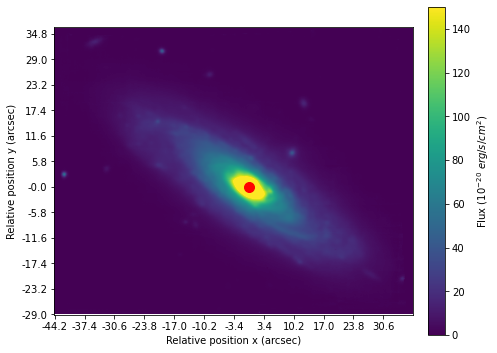

In [25]:
figure, ax = plt.subplots(figsize=(7,7))
plt.imshow(ImageAllambda, origin='lower', vmin=0, vmax=150)
plt.plot(CoordinatesGalaxyCentroidx, CoordinatesGalaxyCentroidy, 'ro', markersize=10)
xaxis = np.arange(0, AxisLength1, 17*2)
yaxis = np.arange(0, AxisLength2, 29) # 29 is a submultiple of CoordinatesGalaxycentroidy, we observe 0.0 this way
xlabels = -(PixelScale*xaxis + nx)*3600 # *3600 to convert deg to arcsec
ylabels = -(PixelScale*yaxis + ny)*3600
formattedListxlabels = ["%.1f" % xlabel for xlabel in xlabels]
formattedListylabels = ["%.1f" % ylabel for ylabel in ylabels]
plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.042, pad=0.04)
plt.show

## 1.7.  a. Image in I band

We concatenate all the images in the range of the I band and show it. We use magnitudes instead of flux units (STAMG system). The interval for the I band is (in amstrong):

In [26]:
I = [8060-1490, 8060+1490] # Intervals extracted from wikipedia using 2*FWHM: https://en.wikipedia.org/wiki/Photometric_system.
print('from', I[0], 'to', I[1], 'amstrongs.')

from 6570 to 9550 amstrongs.


And it will correspond to de following interval in channels:

In [27]:
Ichannels = [ToChannelFunction(I[0]), ToChannelFunction(I[1])]
Ichannels

[1456, 3840]

We convert the flux to magnitudes and shoe the image.

In [28]:
FluxdensityI = np.sum(hdul[1].data[Ichannels[0]:Ichannels[1], :, :],  axis=0)*1e-20/(len(hdul[1].data[Ichannels[0]:Ichannels[1], :, :]))
ImageI = -2.5*np.log10(FluxdensityI)-21.1

C:\Users\Fran\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


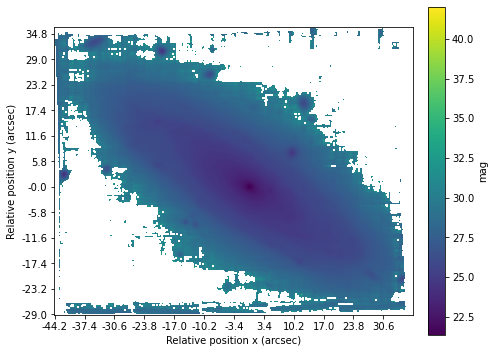

In [29]:
plt.figure(figsize=(7,7))
plt.imshow(ImageI, origin='lower')
plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.colorbar(label='mag', fraction=0.042, pad=0.04)
plt.show()

Some pixels are white because we are using magnitudes as units, that means that we are using logarithms, and some values (thw white ones) are nans.

## 1.7. b. Image in R band

We do the same for the range of the R band.

Wavelengths of the filter:

In [30]:
R = [6580-1380, 6580+1380] # reference (1). We take 2*FWHM.
print('from', R[0], 'to', R[1], 'amstrongs')

from 5200 to 7960 amstrongs


Channel interval:

In [31]:
Rchannels = [ToChannelFunction(R[0]), ToChannelFunction(R[1])]
Rchannels

[360, 2568]

Image:

In [32]:
FluxdensityR = np.sum(hdul[1].data[Rchannels[0]:Rchannels[1], :, :],  axis=0)*1e-20/(len(hdul[1].data[Rchannels[0]:Rchannels[1], :, :]))
ImageR = -2.5*np.log10(FluxdensityR)-21.1

C:\Users\Fran\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


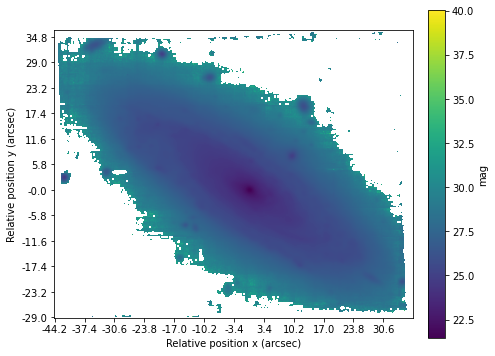

In [33]:
plt.figure(figsize=(7,7))
plt.imshow(ImageR, origin='lower')
plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.colorbar(label='mag', fraction=0.042, pad=0.04)
plt.show()

## 1.8. Image R-I

Now we substract the previous images to study some features.

In [34]:
ImageRminusI = ImageR-ImageI

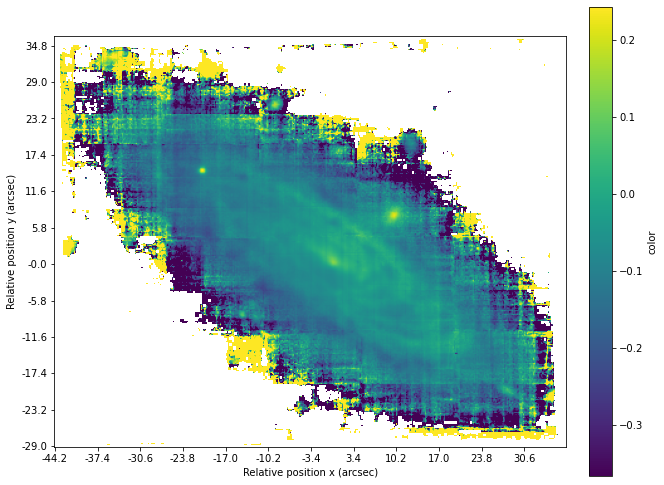

In [35]:
statsRI = imstatsa(ImageRminusI)
plt.figure(figsize=(10,10))
plt.imshow(ImageRminusI, origin='lower', vmin=statsRI['mean']-0.5*statsRI['standard deviation'], vmax=statsRI['mean']+0.5*statsRI['standard deviation'])
plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.colorbar(label='color', fraction=0.042, pad=0.04)
plt.show()

R is the bluer filter because its wavelengths are lower than for the I filter. Then, the more negative R-I is, the bluer the region is. We observe that the bluer zones are outside the galaxy and the redder regions are the arms and specially the center. This is due to the fact that the older stelar poblations are in the center and that the dust is located in the arms, which creates extinction and then makes the zone redder.

## 1.9. Image in H-alpha

Now we work around the H-alpha line. We will show the image without the adjacent continuum emition. Firts, we localize the corresponding channel to the H-alpha (LambdaHaEmit) line and concantenate the image around it for a few pixels. But we must take into accound the redshift z (obtained from ned web) of our galaxy and calculate the observed wavelength of the H-alpha line (LambdaHaObs)

The channel is:

In [36]:
LambdaHaEmit = 6563
z = 0.029
LambdaHaObs = LambdaHaEmit*(1+z)
ChannelHa = ToChannelFunction(LambdaHaObs)

We concatenate for 60 pixels centered at the channel mentioned, 30 to the right and 30 to the left.

In [37]:
LimitLeft = ChannelHa - 30
LimitRight = ChannelHa + 30
npixels = 60
ImageHaFlux = np.sum(hdul[1].data[LimitLeft:LimitRight, :, :],  axis=0)

We also calculate the continuum value nearby (we use 30 pixel lines)


In [38]:
Left = LimitLeft - 30
Right = LimitRight + 30
ImageHaFluxLeft = np.sum(hdul[1].data[Left:LimitLeft, :, :], axis=0)
ImageHaFluxRight = np.sum(hdul[1].data[LimitRight:Right, :, :], axis=0)
Continuum = ImageHaFluxLeft + ImageHaFluxRight

The resulting image is the following. We also plot on it a pixel whose spectrum will be shown.

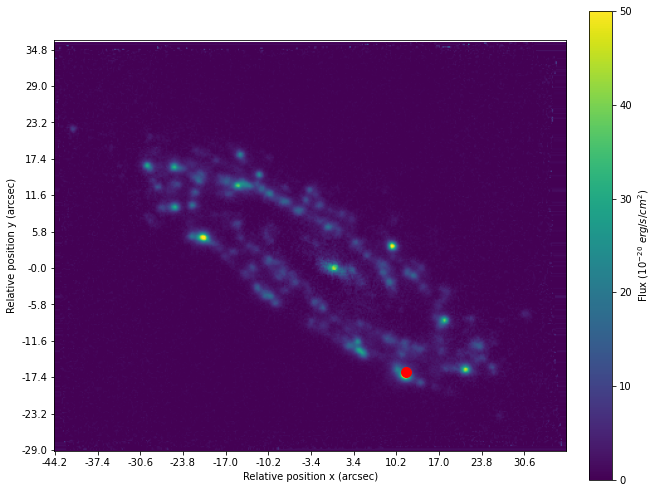

In [39]:
Pixel = [280, 62]
ImageHa = (ImageHaFlux - Continuum)/npixels
stats12 = imstatsa(ImageHa)
plt.figure(figsize=(10,10))
plt.imshow(ImageHa, vmin=0, vmax= 50, origin='lower')
plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.042, pad=0.04)
plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.plot(Pixel[0], Pixel[1], 'ro', markersize=10)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.show()

The count bar is in flux, however, we must take into account that continuum emission has been removed.

For a pixel in which we observe ionized gas, like the one in the calculated center, we obtained the spectrum and try to identify some lines.

Text(0, 0.5, 'Flux $(10^{-20} \\ erg/s/cm^{2})$')

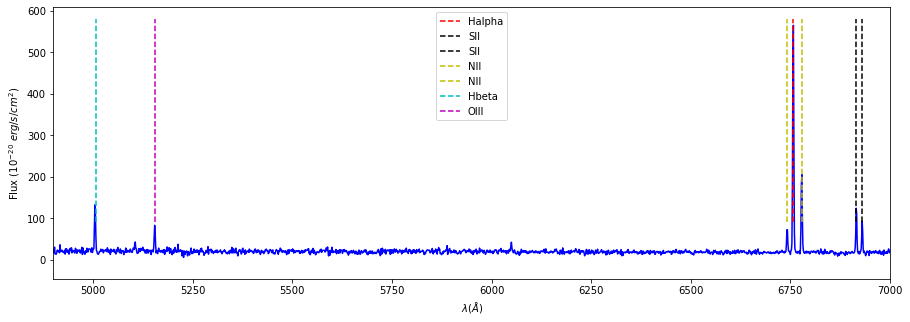

In [40]:
dataLines = hdul[1].data
ydataLines = dataLines[:, Pixel[1], Pixel[0]]
plt.figure(figsize=(15,5))
plt.plot(xdata, ydataLines, 'b')
plt.xlim([4900, 7000])
#plt.ylim([200, 1300])
line = np.arange(90, 580)
Ha = 6757*np.ones(len(line))
SII1 = 6914*np.ones(len(line))
SII2 = 6929*np.ones(len(line))
NII1 = 6742*np.ones(len(line))
NII2 = 6779*np.ones(len(line))
Hbeta = 5007*np.ones(len(line))
OIII = 5155*np.ones(len(line))
plt.plot(Ha, line, 'r--', label='Halpha')
plt.plot(SII1, line, 'k--', label='SII')
plt.plot(SII2, line, 'k--', label='SII')
plt.plot(NII1, line, 'y--', label='NII')
plt.plot(NII2, line, 'y--', label='NII')
plt.plot(Hbeta, line, 'c--', label='Hbeta')
plt.plot(OIII, line, 'm--', label='OIII')
plt.legend()
plt.xlabel(r'$\lambda (Å)$')
plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')

We find the best fit for these lines and measure the noise around each of them.

H-beta signal/noise = 46.798200
OIII signal/noise = 15.232096
NII signal/noise = 29.379916
H-alpha signal/noise = 276.168292
NII signal/noise = 53.733513
SII signal/noise = 63.408849
SII signal/noise = 25.152488


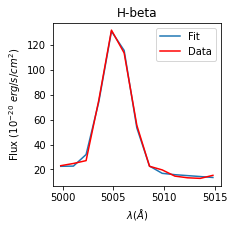

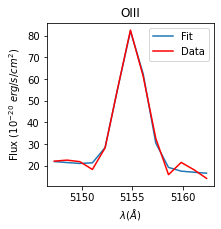

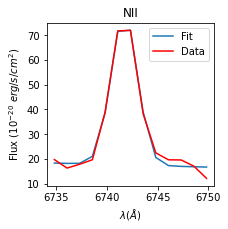

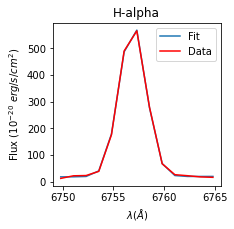

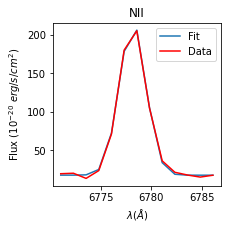

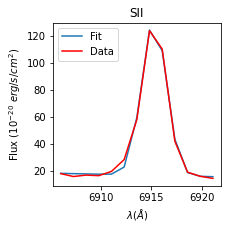

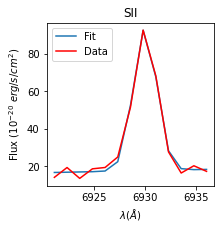

In [41]:
Centeredat = [5007, 5155, 6742, 6757, 6779, 6914, 6929]
Titles = ['H-beta', 'OIII', 'NII', 'H-alpha', 'NII', 'SII', 'SII']
LambdaObsCentersForz = []
for index, value in enumerate(Centeredat):
    LimitsXLeft = Centeredat[index]-8
    LimitsXRight = Centeredat[index]+8
    meanToUse = Centeredat[index]
    g1 = models.Gaussian1D(amplitude=100, mean=meanToUse, stddev=4)
    g2 = models.Polynomial1D(degree=1)
    gg_init = g1 + g2
    fitter = fitting.LevMarLSQFitter()
    wvp = xdata[(xdata>LimitsXLeft)&(xdata<LimitsXRight)]
    wvdatap = ydataLines[(xdata>LimitsXLeft)&(xdata<LimitsXRight)]
    gg_fit = fitter(gg_init, wvp, wvdatap)
    noise = np.std(ydataLines[(xdata>Centeredat[index]+40)&(xdata<Centeredat[index]+50)])
    signal = gg_fit[0].amplitude.value
    sn = signal/noise
    plt.figure(figsize=(3, 3))
    print( Titles[index], 'signal/noise = %f' %sn)
    plt.title(Titles[index])
    plt.plot(wvp, gg_fit(wvp), label='Fit')
    plt.plot(wvp, wvdatap, 'r-', label='Data')
    plt.xlabel(r'$\lambda (Å)$')
    plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
    plt.legend()

## 1.10. Redshift of the galaxy using the spectrum

We will use the H-alpha line to calculate the redshift of the galaxy. We can do a zoom in our spectra and find it exactly using a gaussian fit. We do it first for the center of the galaxy.

Text(0, 0.5, 'Flux $(10^{-20} \\ erg/s/cm^{2})$')

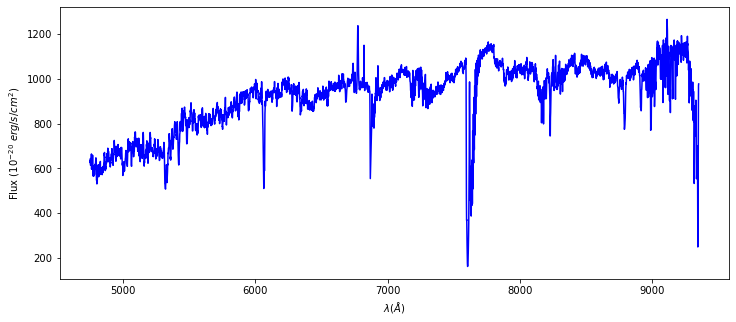

In [42]:
dataCenter = hdul[1].data
ydataCenter = dataCenter[:, 145, 221]
plt.figure(figsize=(12,5))
plt.plot(xdata, ydataCenter, 'b')
plt.xlabel(r'$\lambda (Å)$')
plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')

Doing a zoom we identify some lines. The one in the center is the H-alpha line.

Text(0, 0.5, 'Flux $(10^{-20} \\ erg/s/cm^{2})$')

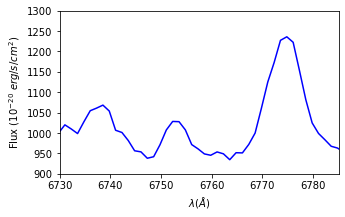

In [43]:
plt.figure(figsize=(5,3))
plt.plot(xdata, ydataCenter, 'b')
plt.xlim([6730, 6785])
plt.ylim([900, 1300])
plt.xlabel(r'$\lambda (Å)$')
plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')

We can now do a gaussian fit just with a range around the peak:

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=95.32627578, mean=6752.85668535, stddev=2.22676027)>

    [1]: <Polynomial1D(1, c0=-7669.0236067, c1=1.27454143)>
Parameters:
       amplitude_0          mean_0      ...        c0_1               c1_1      
    ----------------- ----------------- ... ------------------ -----------------
    95.32627577575477 6752.856685345866 ... -7669.023606701792 1.274541431995596


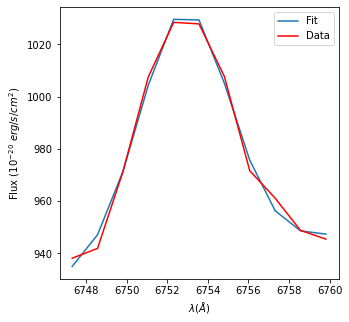

In [44]:
g1 = models.Gaussian1D(amplitude=100, mean=6753, stddev=3)
g2 = models.Polynomial1D(degree=1)
gg_init = g1 + g2
fitter = fitting.LevMarLSQFitter()
wv = xdata[(xdata>6747)&(xdata<6760)]
wvdata = ydataCenter[(xdata>6747)&(xdata<6760)]
gg_fit = fitter(gg_init, wv, wvdata)
print(gg_fit)

plt.figure(figsize=(5,5))
plt.plot(wv,gg_fit(wv), label='Fit')
plt.plot(wv, wvdata, 'r-', label='Data')
plt.xlabel(r'$\lambda (Å)$')
plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
plt.legend()

The redshift z can be calculated now knowing that the wavelength at rest is 6563 angstroms.

In [45]:
LambdaObsCenter = gg_fit[0].mean.value
z = LambdaObsCenter/LambdaHaEmit - 1
print('z = %f' %z)

z = 0.028928


We can do the same for several points. They are calles Point 0, Point 1... going from left to right in the x axis.

<function matplotlib.pyplot.show(close=None, block=None)>

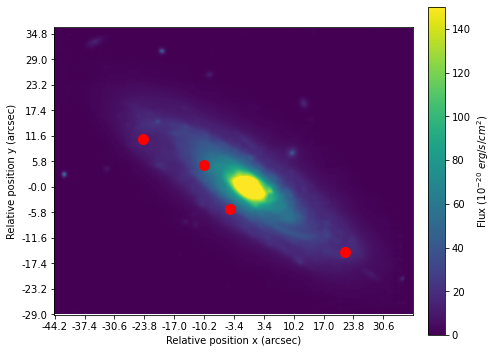

In [46]:
plt.figure(figsize=(7,7))
plt.imshow(ImageAllambda, origin='lower', vmin=0, vmax=150)
pointz1 = [100, 200]
pointz2 = [170, 170]
pointz3 = [200, 120]
pointz4 = [330, 71]
pointsz = [pointz1, pointz2, pointz3, pointz4]
for index in np.arange(0, len(pointsz)):
    plt.plot(pointsz[index][0], pointsz[index][1],'ro', markersize=10)

plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.042, pad=0.04)
plt.show

In [47]:
SpectraPointsz = [data[:, point[1], point[0]] for point in pointsz]

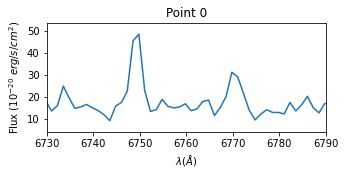

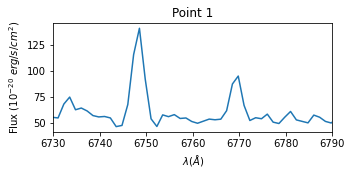

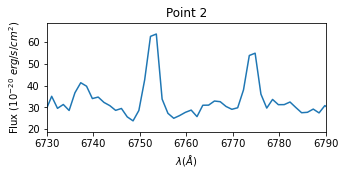

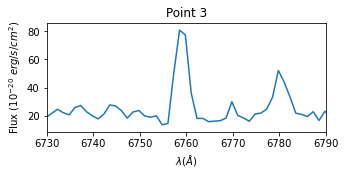

In [48]:
for index in np.arange(0, len(pointsz)):
    plt.figure(figsize=(5,2))
    plt.title('Point %i' %index)
    plt.plot(xdata, SpectraPointsz[index])
    limitxmin = 6730
    limitxmax = 6790
    limitymax = max(SpectraPointsz[index][(xdata>limitxmin)&(xdata<limitxmax)]) + 5
    limitymin = min(SpectraPointsz[index][(xdata>limitxmin)&(xdata<limitxmax)]) - 5
    plt.xlim([limitxmin, limitxmax])
    plt.ylim([limitymin, limitymax])
    plt.xlabel(r'$\lambda (Å)$')
    plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
    plt.show()

We easily identify the H-alpha line, so we do the fitting as before for each point.

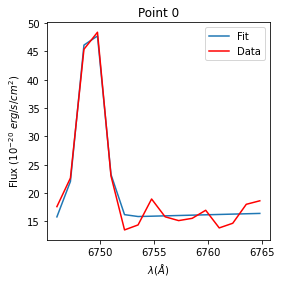

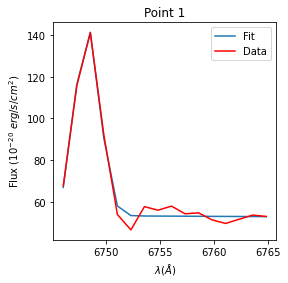

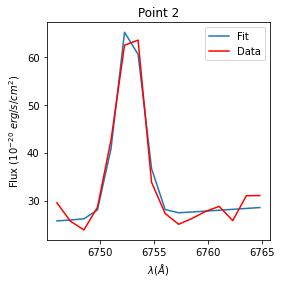

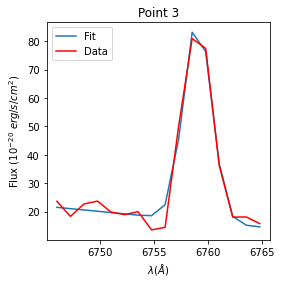

In [49]:
LimitsXLeft = 6745
LimitsXRight = 6765
LambdaObsCentersForz = []
for index in np.arange(0, len(pointsz)):
    maxInTheRange = max(SpectraPointsz[index][(xdata>LimitsXLeft)&(xdata<LimitsXRight)])
    meanToUse = xdata[SpectraPointsz[index]==maxInTheRange]
    g1 = models.Gaussian1D(amplitude=100, mean=meanToUse, stddev=3)
    g2 = models.Polynomial1D(degree=1)
    gg_init = g1 + g2
    fitter = fitting.LevMarLSQFitter()
    wvp = xdata[(xdata>LimitsXLeft)&(xdata<LimitsXRight)]
    wvdatap = SpectraPointsz[index][(xdata>LimitsXLeft)&(xdata<LimitsXRight)]
    gg_fit = fitter(gg_init, wvp, wvdatap)
    LambdaObsCentersForz.append(gg_fit[0].mean.value) 
    plt.figure(figsize=(4, 4))
    plt.title('Point %i' %index)
    plt.plot(wvp, gg_fit(wvp), label='Fit')
    plt.plot(wvp, wvdatap, 'r-', label='Data')
    plt.xlabel(r'$\lambda (Å)$')
    plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
    plt.legend()

We calculate now the redshift for the different points, respectively we get:

In [50]:
LambdaObsCentersForz.append(LambdaObsCenter)
zArray = [LambdaObs/LambdaHaEmit-1 for LambdaObs in LambdaObsCentersForz]
print(zArray)

[0.028375271817216996, 0.028232048893758188, 0.02891769795271748, 0.029872572724733315, 0.02892833846501075]


And its mean:

In [51]:
zArrayMean = np.mean(zArray)
print('z = %.3f' %zArrayMean)

z = 0.029


We observe that the number is equal to the one given by NED. We can, although, observe that different points have different redshift (not a big change though) due to the rotation of the galaxy itself since it provokes a wavelenth change due to doppler effect (one side is approching while the other one is going away from us).

## 2.1. Generation of images around H-alpha line

Considering what we did in the previous steps, the H-alpha line is near 6753 angstroms. We will use ranges of 10 angstroms to create images in a total range of 200 angstroms.

In [52]:
HaLine = 6753
Intervals = np.arange(0, 66, 2)
ImagesAroundHa = [np.sum(data[ToChannelFunction((HaLine-33)+i):ToChannelFunction((HaLine-33)+2+i), :, :]/20,
                         axis=0) for i in Intervals]

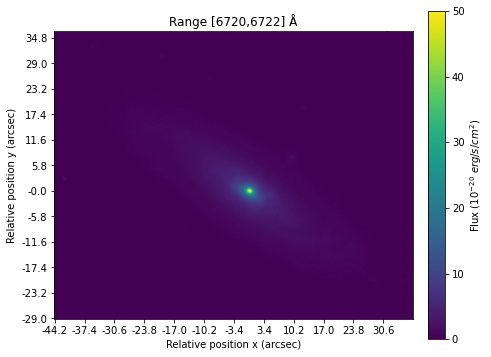

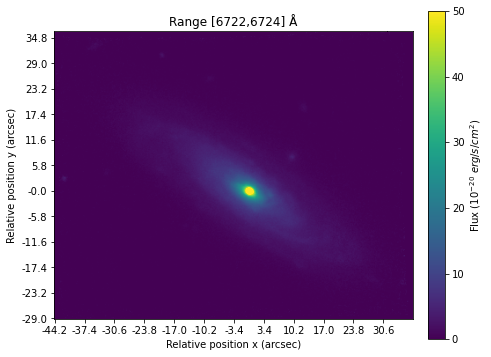

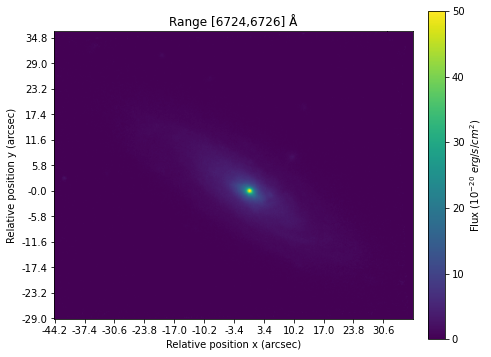

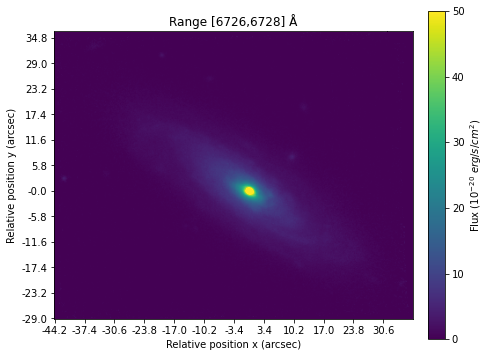

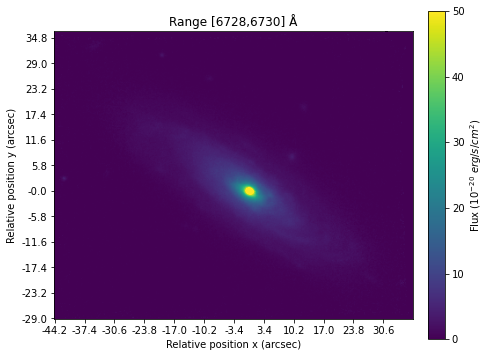

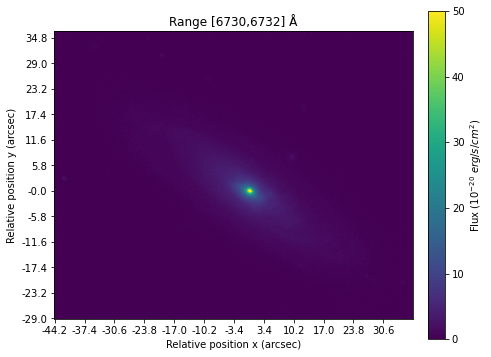

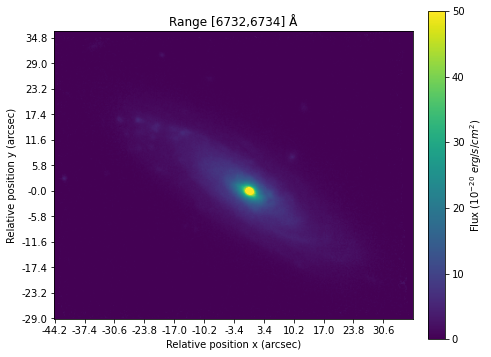

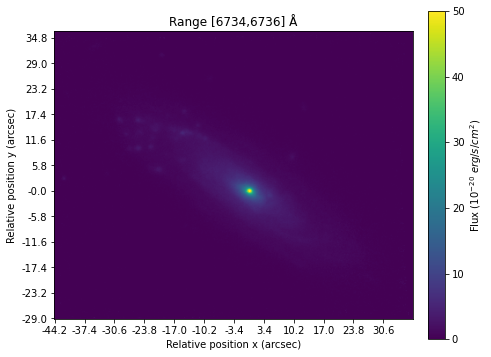

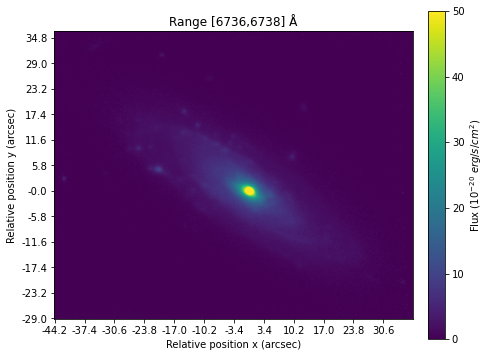

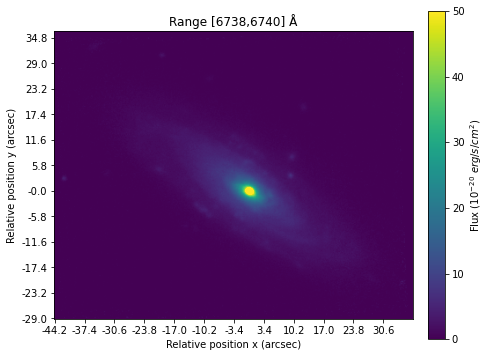

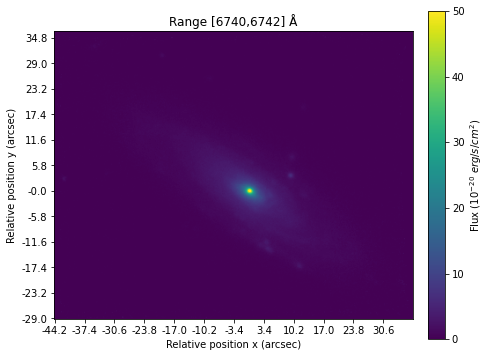

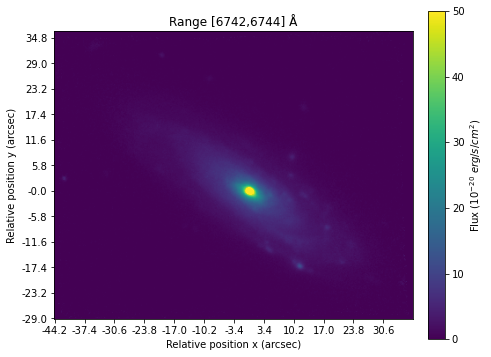

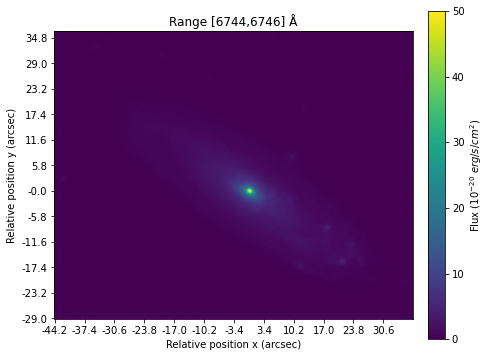

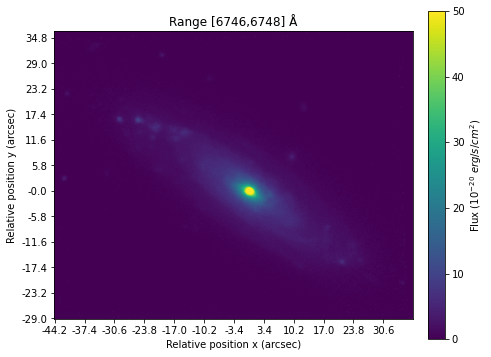

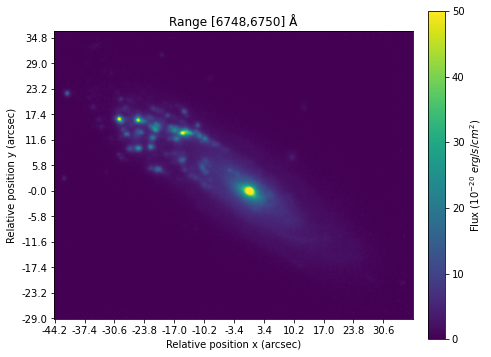

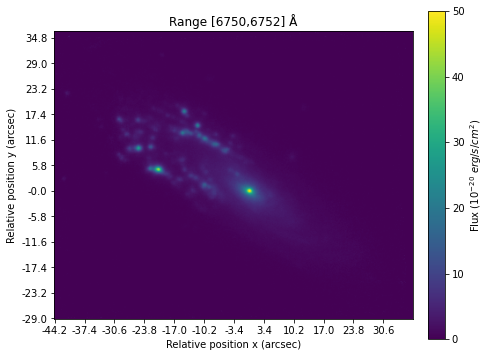

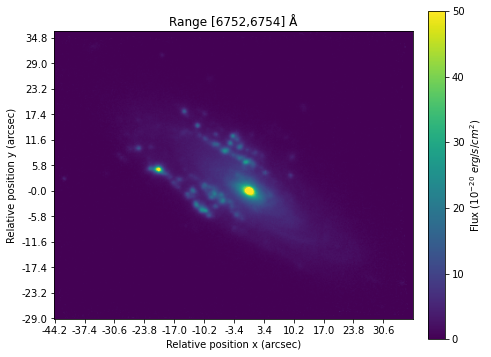

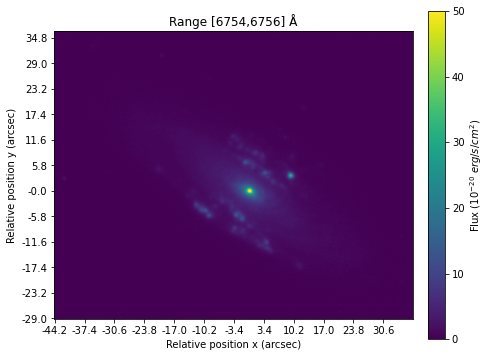

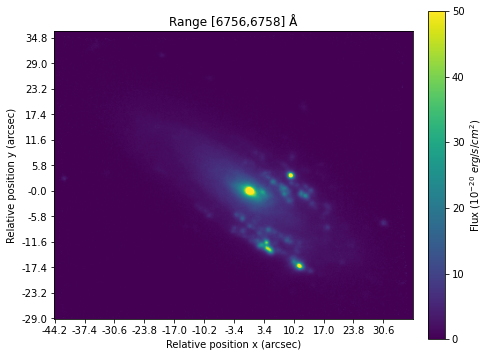

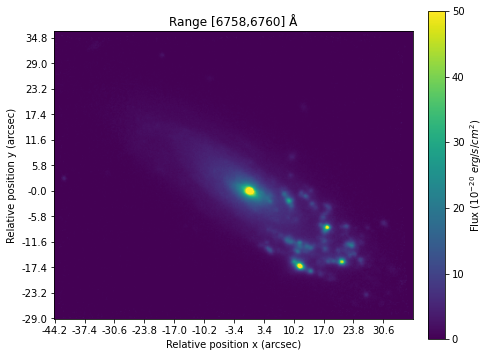

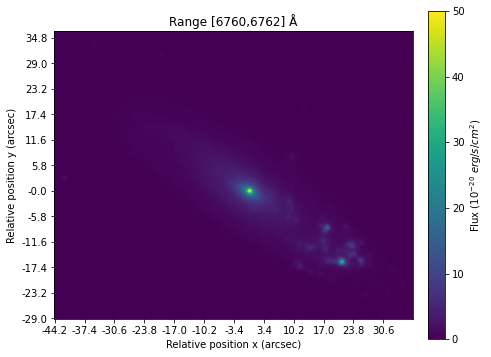

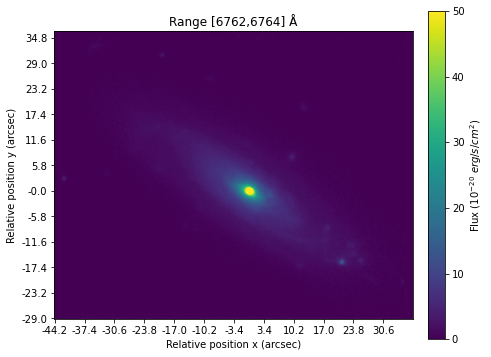

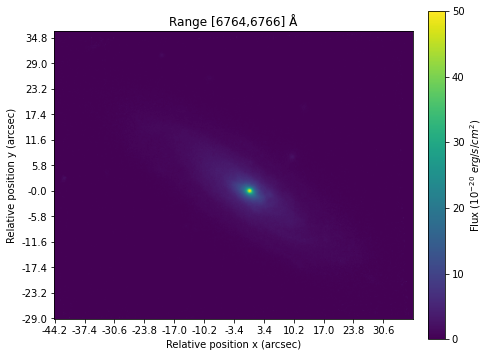

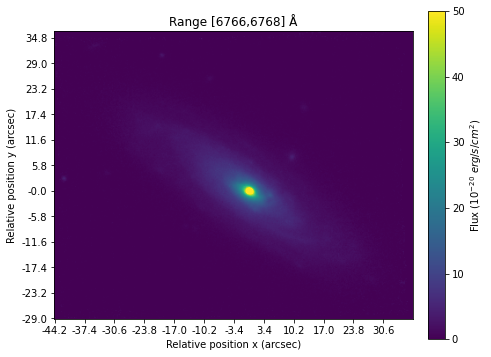

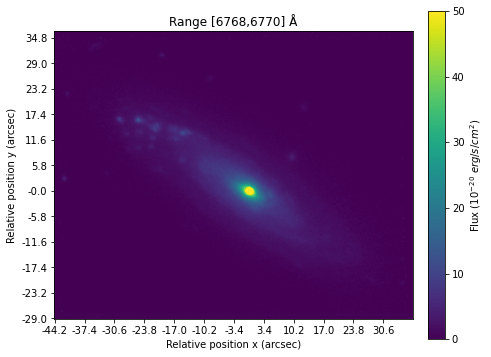

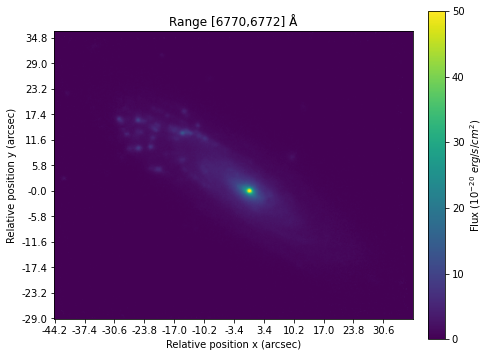

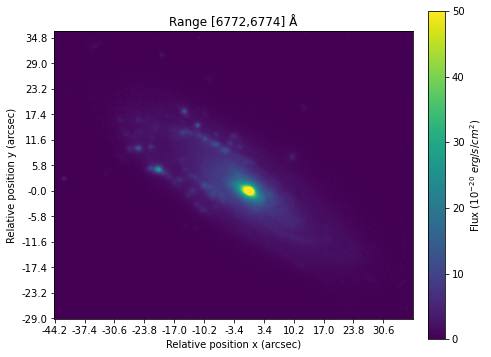

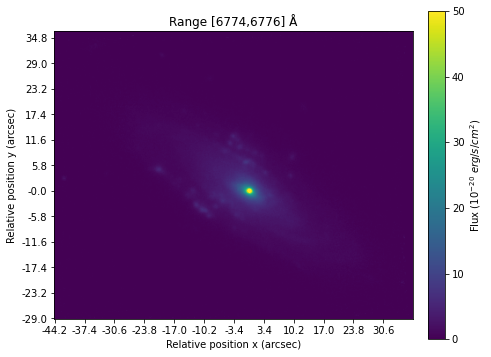

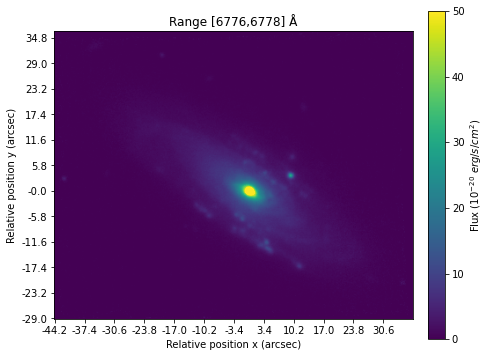

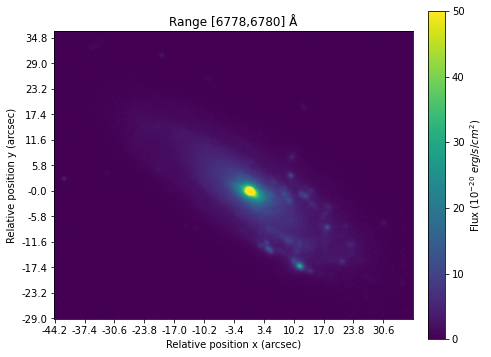

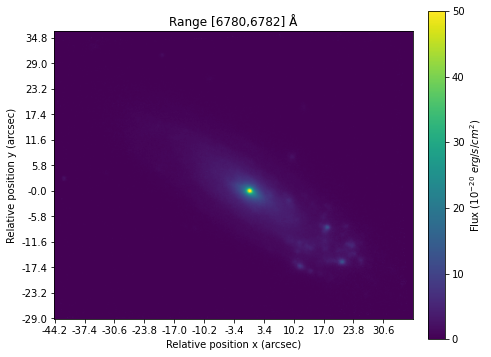

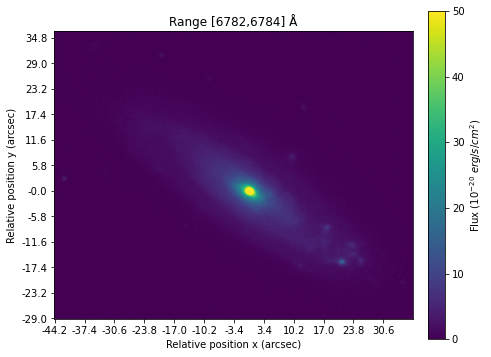

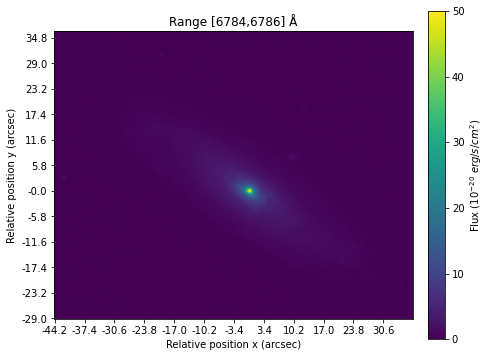

In [53]:
IntervalsReal = [(HaLine-33)+i for i in Intervals]
for index, i in zip(np.arange(0, len(ImagesAroundHa)), IntervalsReal):
    plt.figure(figsize=(7,7))
    plt.imshow(ImagesAroundHa[index], vmin=0, vmax=50, origin='lower')
    plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.042, pad=0.04)
    plt.xticks(xaxis, formattedListxlabels)
    plt.yticks(yaxis, formattedListylabels)
    plt.xlabel('Relative position x (arcsec)')
    plt.ylabel('Relative position y (arcsec)')
    j = IntervalsReal[index] + 2
    plt.title("Range [%i" %i + ",%i]" %j + " Å")
#   plt.savefig('forGIF %i' %index)
    plt.show()

## 2.2. GIF 

With the images generated in 2.1 we create a GIF.

The lines are displayed as Raw NBConvert since we had already created the gift and it will give us an error y try to do it again under the same name. It is the same reason why we have marked 'plt.savefig...' as a comment a few cells above.

In the GIF we can observe how for the ranges that contain the H-alpha line, the H-alpha regions suddenly appear from left to right and vanish again once we have passed them. The regions are not seen at once because of the rotation of the galaxy that provokes a wavelength chage due to doppler effect (one side is approching while the other one is going away from us). We also observe that some areas of the galaxy iluminates (but faintly) before and after the ilimination of the H-alpha regions, this is due to the lines of NII.

## 2.3. Rotation curve

We are now going to obtain the rotation curve of the galaxy. Taking into account that the position angle of the galaxy is 56 degrees we can draw the major axis of the ellipse and obtain the spectrum of several points along it, and also calculate their distance from the center of the galaxy (we must consider that the distance between the galaxy and us is 126.60 Mpc according to NED). Using the spectra we can look for the H-alpha line in each of them and calculate the rotation velocity of each point (knowing that the inclination angle is 71 degrees). With these data is possible to graph the rotation curve of our galaxy.

To begin, we draw the major axis of the ellipse over the H-alpha image and select some points along it.

In [54]:
PositionAngle = 56*np.pi/180

In [55]:
def y(m, x, n):
    return m * x + n

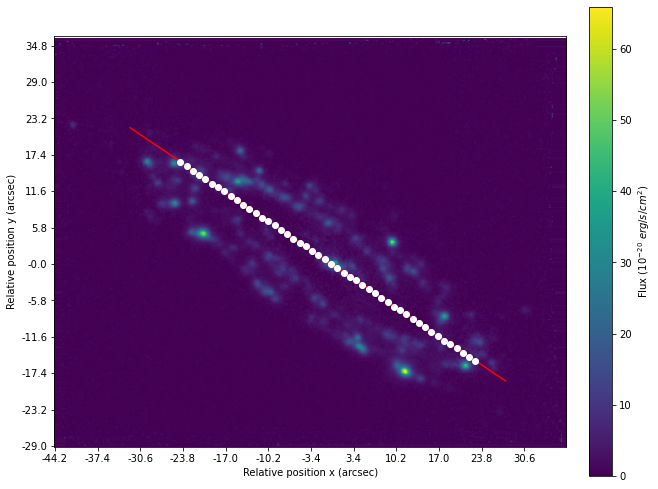

In [56]:
x = np.arange(60, 360)
m = -1/np.tan(PositionAngle)
n = CoordinatesGalaxyCentroidy - m* CoordinatesGalaxyCentroidx
plt.figure(figsize=(10,10))
plt.imshow(ImageHa, vmin=0, origin='lower')
plt.plot(x, y(m, x, n) , '-r')
xpoints = np.arange(100, 340, 5)
ypoints = [int(y(m, xpoint, n)) for xpoint in xpoints]
plt.plot (xpoints, ypoints, 'ow')
plt.colorbar(label='Flux $(10^{-20} \ erg/s/cm^{2})$', fraction=0.042, pad=0.04)
plt.xticks(xaxis, formattedListxlabels)
plt.yticks(yaxis, formattedListylabels)
plt.xlabel('Relative position x (arcsec)')
plt.ylabel('Relative position y (arcsec)')
plt.show()

We obtain the spectra of the white points and focus on finding the H-alpha line.

In [57]:
ydataSpectraPoints = [data[:, ypoints[index], xpoints[index]] for index in np.arange(0, len(xpoints))]

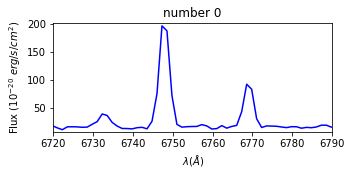

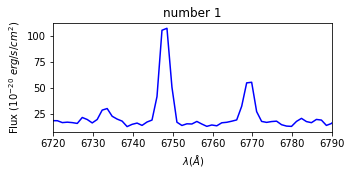

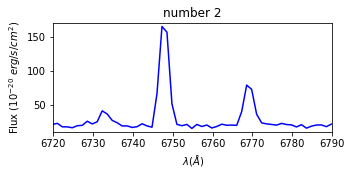

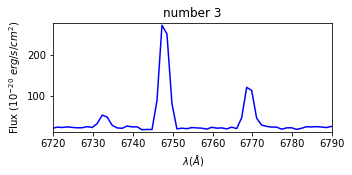

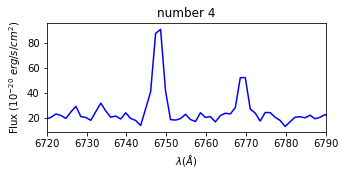

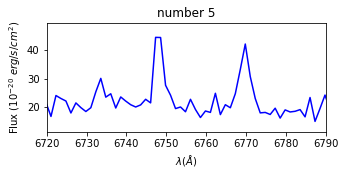

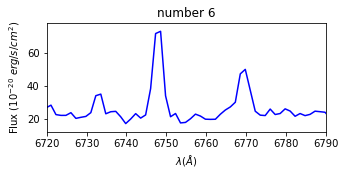

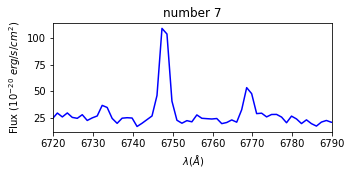

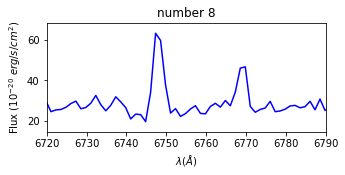

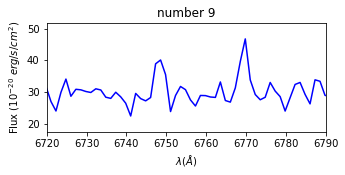

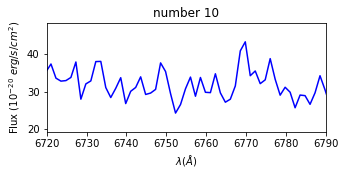

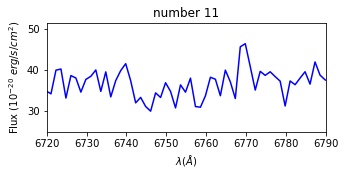

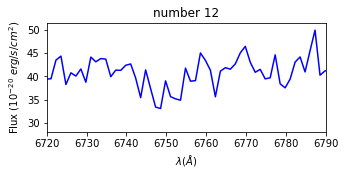

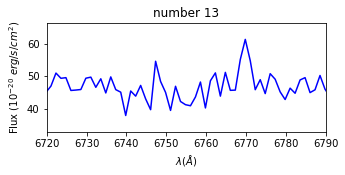

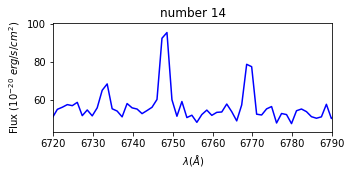

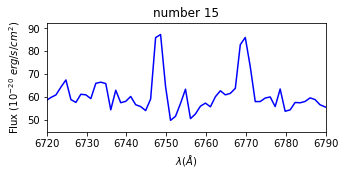

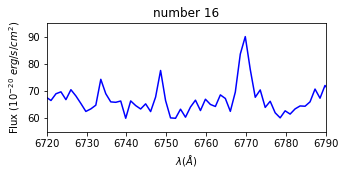

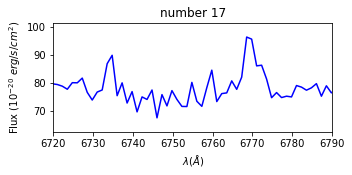

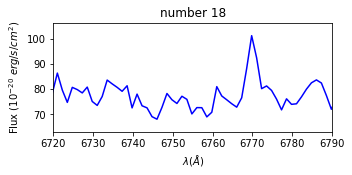

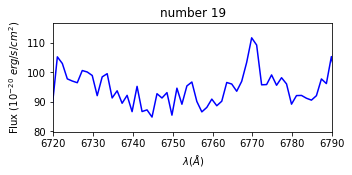

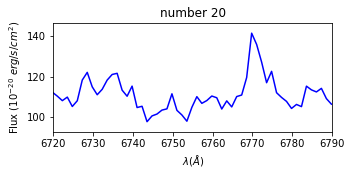

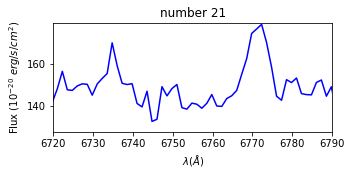

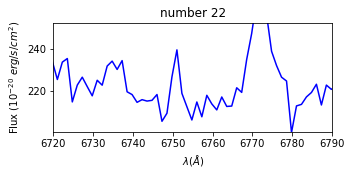

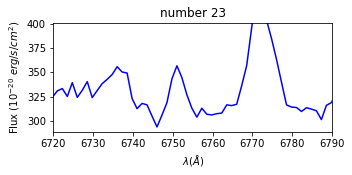

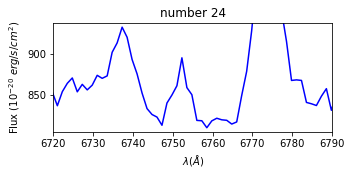

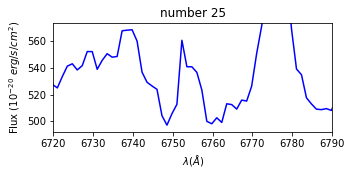

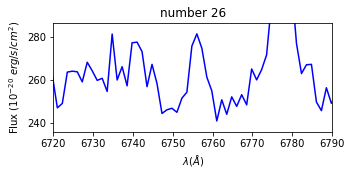

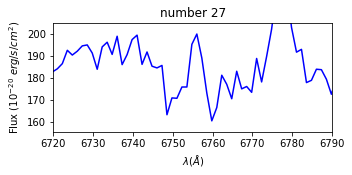

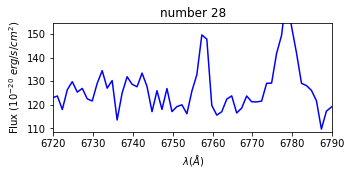

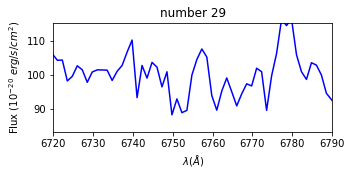

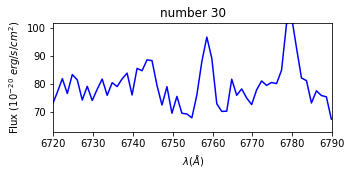

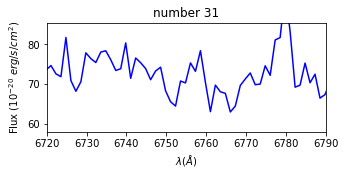

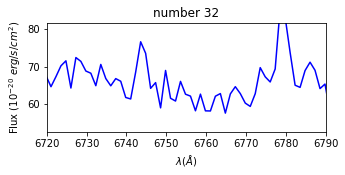

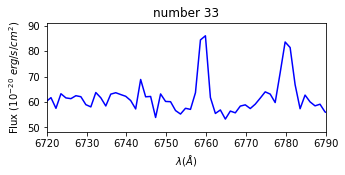

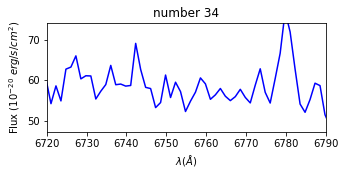

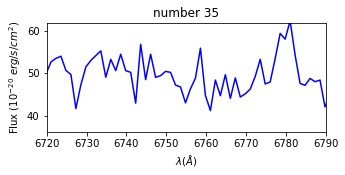

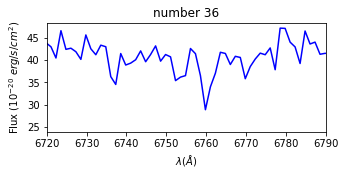

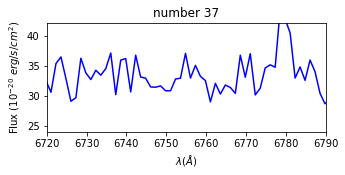

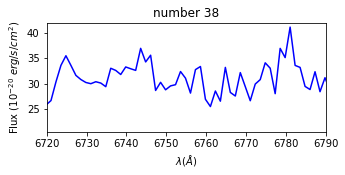

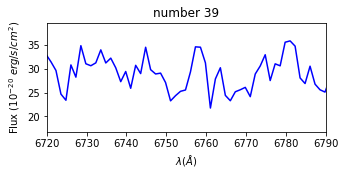

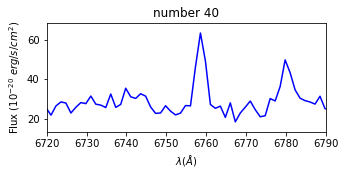

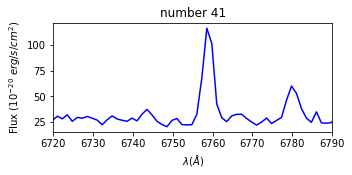

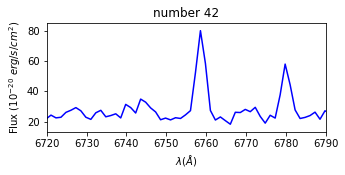

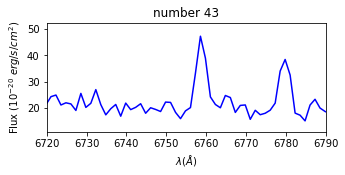

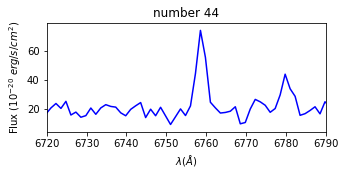

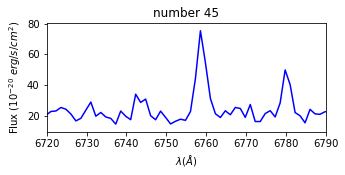

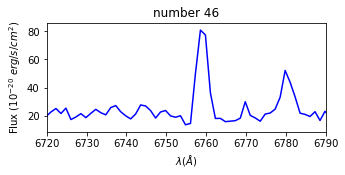

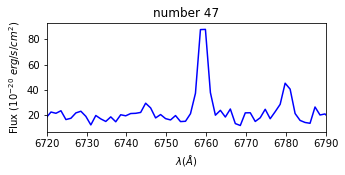

In [58]:
for index in np.arange(0, len(ydataSpectraPoints)):
    plt.figure(figsize=(5,2))
    plt.title('number %i' %index)
    plt.plot(xdata, ydataSpectraPoints[index], 'b-')
    limitymax = max(ydataSpectraPoints[index][(xdata>6730)&(xdata<6770)]) +5
    limitymin = min(ydataSpectraPoints[index][(xdata>6730)&(xdata<6770)]) -5
    plt.xlim([6720, 6790])
    plt.ylim([limitymin, limitymax])
    plt.xlabel(r'$\lambda (Å)$')
    plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
    plt.show()

We can observe that the alpha peak is moving in each plot. There are some plots in which the line does not appear, so these plots are not useful and will be deleted:

In [59]:
Valid1 = np.arange(0, 9)
Valid2 = np.arange(14, 16)
Valid3 = np.arange(22, 30)
Valid4 = np.arange(40, 48)
Valid = [*Valid1, 33, *Valid2, *Valid3, *Valid4]

In [60]:
ydataSpectraPointsValid = []
for index, value in enumerate(ydataSpectraPoints):
    if index in Valid:
        ydataSpectraPointsValid.append(ydataSpectraPoints[index])

We proceed now to show the spectra and the fitting for the valid ones.

C:\Users\Fran\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


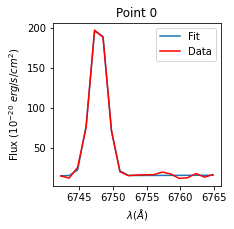

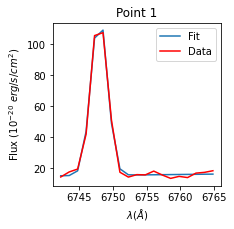

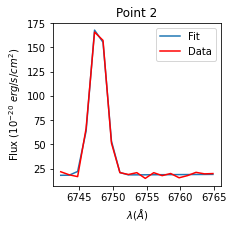

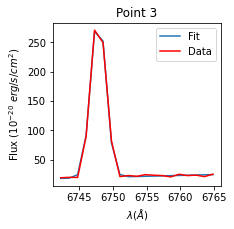

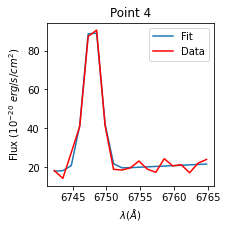

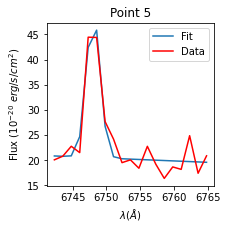

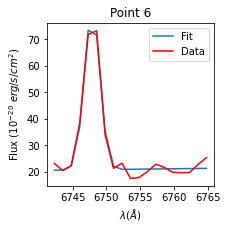

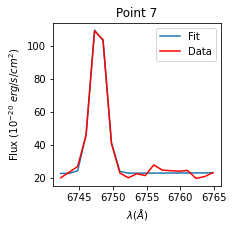

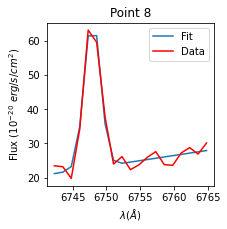

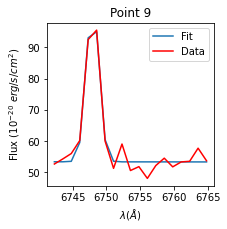

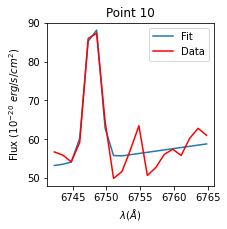

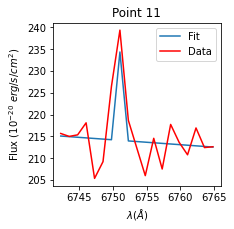

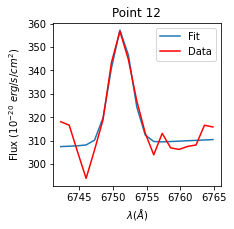

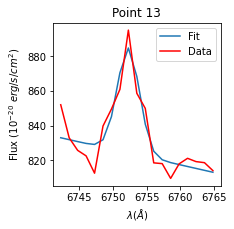

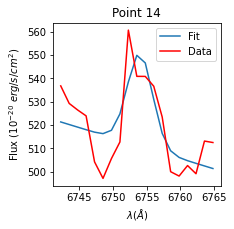

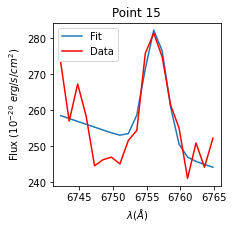

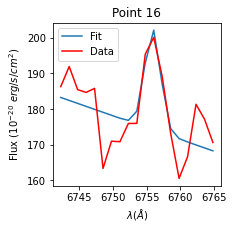

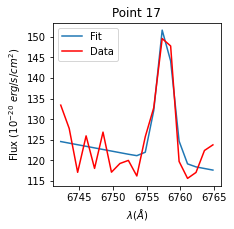

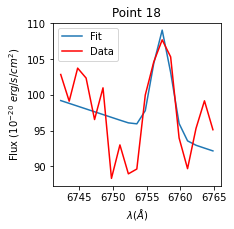

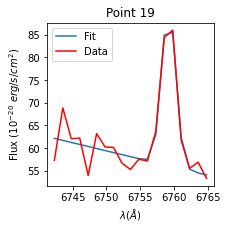

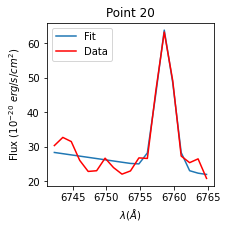

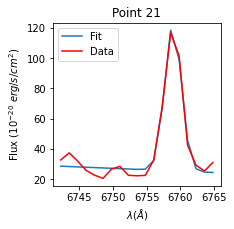

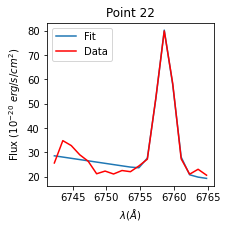

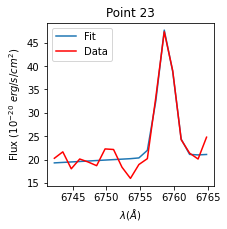

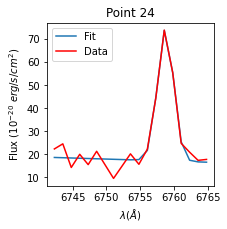

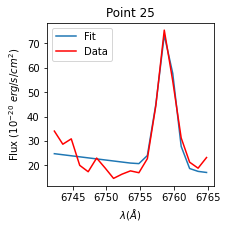

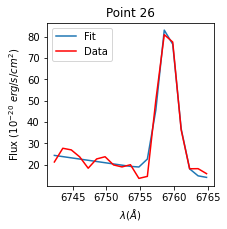

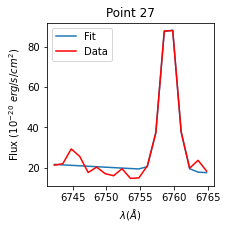

In [61]:
LimitsXLeft = 6742
LimitsXRight = 6765
LambdaObsCentersForRot = []
for index, value in enumerate(ydataSpectraPointsValid):
    maxInTheRange = max(ydataSpectraPointsValid[index][(xdata>LimitsXLeft)&(xdata<LimitsXRight)])
    meanToUse = xdata[ydataSpectraPointsValid[index]==maxInTheRange]
    g1 = models.Gaussian1D(amplitude=100, mean=meanToUse, stddev=2)
    g2 = models.Polynomial1D(degree=1)
    gg_init = g1 + g2
    fitter = fitting.LevMarLSQFitter()
    wvp = xdata[(xdata>LimitsXLeft)&(xdata<LimitsXRight)]
    wvdatap = ydataSpectraPointsValid[index][(xdata>LimitsXLeft)&(xdata<LimitsXRight)]
    gg_fit = fitter(gg_init, wvp, wvdatap)
    LambdaObsCentersForRot.append(gg_fit[0].mean.value) 
    plt.figure(figsize=(3, 3))
    plt.title('Point %i' %index)
    plt.plot(wvp, gg_fit(wvp), label='Fit')
    plt.plot(wvp, wvdatap, 'r-', label='Data')
    plt.xlabel(r'$\lambda (Å)$')
    plt.ylabel('Flux $(10^{-20} \ erg/s/cm^{2})$')
    plt.legend()

We can get the rotation velocity now since we know the position of the H-alpha peak in our spectra. If $\lambda_{center}$ is the wavelength of the H-alpha line for the center of the galaxy (already calculated), $\lambda_{point}$ is the wavelength of the H-alpha line for the other points, $v_{obs}$ is the velocity of the point in the vision line respect to the center of the galaxy and $c$ is the speed of light in vaccuum, we have the following relation:

In [62]:
display(Math(r'\frac{\lambda_{center} - \lambda_{point}}{\lambda_{point}} = \frac{v_{obs}}{c}'))

<IPython.core.display.Math object>

And we obtain $v_{obs}$.

In [63]:
LambdaObsCentersForRotArray = np.array(LambdaObsCentersForRot) # we convert it into an array so we can
                                                               # directly operate, with a list is not
                                                               # possible like this and more actions are required 
                                                               # (as done to obtain the redshifts)
c = 3e5 # km/s
v_obs = c*abs(LambdaObsCenter - LambdaObsCentersForRotArray)/LambdaObsCentersForRotArray # km/s

Taking into account that the inclination angle i is 71 degrees and that the points are along the major axis we can obtain the rotation velocity $v_r$ as

In [64]:
display(Math(r'v_r = \frac{v_{obs}}{\sin i}'))

<IPython.core.display.Math object>

In [65]:
i = 71 * np.pi / 180
v_r = v_obs/np.sin(i)

Next, we calculate the distance of the selected valid points respect to the center of the galaxy knowing that the ditance d between us and the galxy is 126.60 Mpc.

In [66]:
ypointsValid = []
for index, value in enumerate(ypoints):
    if index in Valid:
        ypointsValid.append(ypoints[index])
ypointsValidArray = np.array(ypointsValid)

xpointsValid = []
for index, value in enumerate(xpoints):
    if index in Valid:
        xpointsValid.append(xpoints[index])
xpointsValidArray = np.array(xpointsValid)

We obtain the relation to transform pixels into distance.

In [67]:
display(Math(r'1\ pix/pc = d \cdot PixelScale \cdot \frac{\pi}{180} '))

<IPython.core.display.Math object>

In [68]:
d = 126.6e6 # pc
RelationPixPc = d * PixelScale * np.pi/180

The distance between the points and the center in pixels is

In [69]:
distancepix = np.sqrt((xpointsValidArray-CoordinatesGalaxyCentroidx)**2 + (ypointsValidArray-CoordinatesGalaxyCentroidy)**2) # pixs

The distance in pc is

In [70]:
distancepc = distancepix * abs(RelationPixPc)

We can plot the rotation curve.

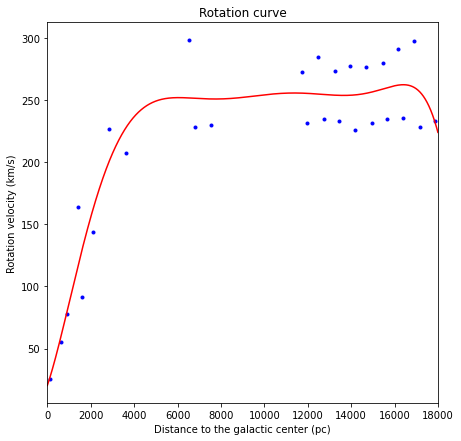

In [71]:
fitparam = np.polyfit(distancepc, v_r, 7)
p = np.poly1d(fitparam)
plt.figure(figsize=(7,7))
plt.title('Rotation curve')
plt.plot(distancepc, v_r, 'b.')
xrray = np.arange(0, 18000)
plt.plot(xrray, p(xrray), 'r-')
plt.xlabel('Distance to the galactic center (pc)')
plt.ylabel('Rotation velocity (km/s)')
plt.xlim(0, 18000)
plt.show()

We can also obtain a rotation curve based on the mass profile (this is the rotation curve if all the matter in the galaxy is baryonic).

In [72]:
fname = "/Users/Fran/Desktop/Tecnicas_observacionales/perfil_masa.txt" # substitute the path.
dataRotCurveMassProfile = np.loadtxt(fname, comments='#', delimiter=',')
DistancemMP = np.array(dataRotCurveMassProfile[1:, 0]) * 10**3 # m
MassMP = np.array(dataRotCurveMassProfile[1:, 1]) # kg

Using newtonian physics (centripetal force equal to gravitational force) we can obtain the rotation velocity for every distance:

In [73]:
G = 6.67e-11 # m^3/(s^2 * kg)
v_rotMP = np.sqrt(G*MassMP/DistancemMP) # m/s

v_rotMPlist = list(v_rotMP)
v_rotMPlist.insert(0, 0)
v_rotMPFinal = np.array(v_rotMPlist)*0.001 # km/s

DistancemMPlist = list(DistancemMP)
DistancemMPlist.insert(0, 0)
DistancepcMP = np.array(DistancemMPlist) * 3.24e-17

And we plot it.

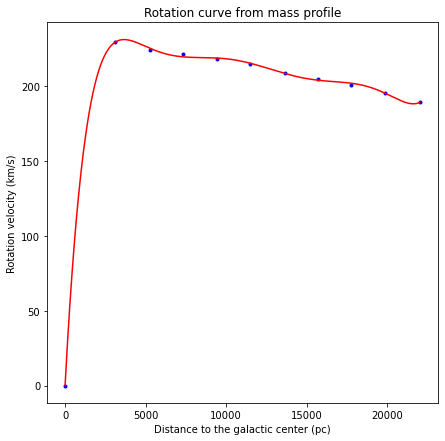

In [74]:
fitparamMP = np.polyfit(DistancepcMP, v_rotMPFinal, 7)
p = np.poly1d(fitparamMP)
plt.figure(figsize=(7,7))
plt.title('Rotation curve from mass profile')
plt.plot(DistancepcMP, v_rotMPFinal, 'b.')
plt.xlabel('Distance to the galactic center (pc)')
plt.ylabel('Rotation velocity (km/s)')
xrray = np.arange(0, 22000)
fit = np.zeros(len(xrray))
for index, value in enumerate(fitparamMP):
    fitforsum = fitparamMP[index]*xrray**(len(fitparamMP)-1-index)
    fit = fit + fitforsum
plt.plot(xrray, p(xrray), 'r-') 
plt.show()

We can observe differences from the one obtained with the other method. The discrepancies come from the fact that in our second method we only consider the baryonic matter, the one that interacts electromagnetically. This tell us that there is more mass than we can observe, the dark matter, which interacts exclusively gravitationally.

# Conclusion

We have found the areas of stelar formation using the H-alpha line, identified some emissions lines for a concrete point in a rich area of ionized gas, obtained the redshift of the galaxy and plotted two different rotation curve (one using spectroscopy and one using the baryonic matter). We arrive at the conclusion that we need dark matter to explain the obtained rotation curve from spectroscopy.